In [2]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.colors as colors
from scipy.stats import norm

from stl import mesh
from mpl_toolkits import mplot3d
import scipy.constants as con

In [3]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [4]:
def GetPhotonFlags(Flags):
    PhotonFlags = {}
    PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
    PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
    PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
    PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
    PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
    PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
    PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
    PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
    PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
    PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
    PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
    PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
    return PhotonFlags

In [5]:
allKeys = ['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 
                  'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 
                  'PhotonWavelength', 'PhotonTime', 'DetectorHit']

# Keys1 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 
#          'InitialPosition', 'DetectedPos', 'PhotonWavelength']

#10 muons, 70 PMTs, QE on - trying to get channel hit time
File1 = "h5_files/chroma_nEXO_OD_OD_70PMT_QE_210719_143945_r1707.h5"
#same but with photonTime variables
File1 = "h5_files/chroma_nEXO_OD_OD_70PMT_QE_210719_163329_r1658.h5"

#first try with muon time passed to photon event, 1 muon straight through center, WT, no QE
File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_TEST_210722_153136_r6574.h5"

Data1 = ReadFile(allKeys, File1)

In [6]:
print(Data1.keys())

# for var in Data1.keys():
#     print(var, "- number of entries:", len(Data1[var]))
#     print("     ", Data1[var], '\n')

dict_keys(['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 'PhotonWavelength', 'PhotonTime', 'DetectorHit'])


## Looking at photon paths

In [7]:
I_pos = Data1['InitialPosition'].T
f_pos = Data1['FinalPosition'].T  
d_pos = Data1['DetectedPos'].T  

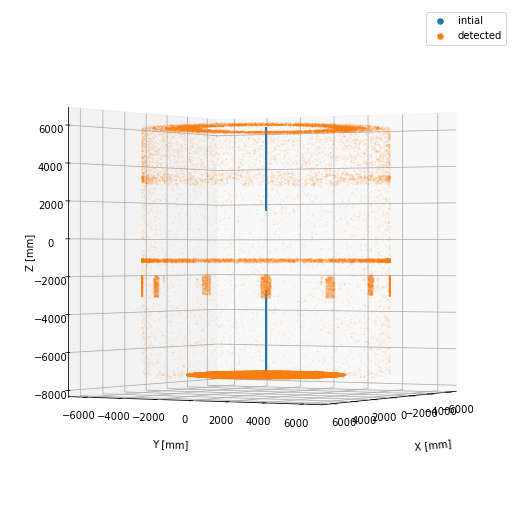

In [14]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(I_pos[0], I_pos[1], I_pos[2], 'blue', label='intial', s=0.9)
# axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1, s=0.6, label='final')

axes.scatter3D(d_pos[0], d_pos[1], d_pos[2], 'orange', alpha=0.1, s=0.6, label='detected')

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

lgnd = axes.legend()

#change the marker size manually for both lines
for L in lgnd.legendHandles:
    L._sizes = [30]
    L.set_alpha(1)
    
#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

## Looking at timing total

In [72]:
def plotLightMapTime(top, side, bottom, title="Light Map", s=30):

    fig, axes = plt.subplots(3, 1, figsize=(6,14))

    Colmap=plt.get_cmap('viridis')
    
    fig.suptitle(title)
    #### top of watertank #####

    plot1 = axes[0].scatter(top[1], top[0], c=top[2], cmap=Colmap, s=s)
    
    axes[0].set_ylabel("X [mm]")
    axes[0].set_xlabel("Y [mm]")
    # axes[0].tick_params(labelbottom=False,labeltop=True)
    axes[0].xaxis.set_ticks_position('top') 
    axes[0].xaxis.set_label_position('top')
    axes[0].set_title('Top', x =1.1, y=0.5,)

    #### wall of watertank #####
    #Azimuthal position [rad]

    plot2 = axes[1].scatter(side[0], side[1], c=side[2], cmap=Colmap, s=s)
        
    axes[1].set_xlabel("Azimuthal position [rad]")
    axes[1].set_ylabel("Z [mm]")
    axes[1].set_title('Wall', x =1.1, y=0.5,)
    axes[1].set_xticks(np.arange(-np.pi, np.pi+0.1, np.pi/4))
    labels = [r'-$\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'-$\pi/4$', '$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$',]
    axes[1].set_xticklabels(labels)


    #### bottom of watertank #####
    plot3 = axes[2].scatter(bottom[1], bottom[0], c=bottom[2], cmap=Colmap, s=s)
        
    axes[2].set_ylabel("X [mm]")
    axes[2].set_xlabel("Y [mm]")
    axes[2].set_title('Bottom', x =1.1, y=0.5,)

    # Find the min and max of all colors for use in setting the color scale.
    images = [plot1, plot2, plot3]
    
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    
    norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    for im in images:
        im.set_norm(norm)


    cbar = fig.colorbar(images[0], ax=axes, shrink=0.95, pad=.14)
    # cbar.set_ticks(np.arange(0, 1.1, 0.5))
    cbar.set_label('Time from Muon entering WT [ns]')
    plt.show()

In [45]:
detectedPos = Data1['DetectedPos']
PhotonTiming = Data1['PhotonTime']

#approximate values to only plot photons with a dimension larger than these for each of the three graphss
topHeight = 5000
bottomHeight = -5000
radius = 6000

#get hits on surfaces
top_hits = []
bottom_hits = []
side_hits = []
all_sides_hits = []
skipped_hits = 0

# PhotonFlags = [GetPhotonFlags(x) for x in Data1['Flags']]
PhotonFlags_flip = GetPhotonFlags(Data1['Flags']) # it's so much faster this way
DetectedBool = PhotonFlags_flip['SURFACE_DETECT']

d = 0

for i, flagtag in enumerate(Data1['Flags']):
#     print(GetPhotonFlags(flagtag))
    if DetectedBool[i]: #only save those that are detected
        x,y,z = detectedPos[d]
        R = np.sqrt(x*x + y*y)
        Az = np.arctan2(y, x)
        
#         print([x,y,z], [R, Az, z])
#         print(z)
        
        #save photons that stopped only near the edge of the WT - to be improved later
        if z >= topHeight:
#             print(z)
            top_hits.append([x,y,PhotonTiming[i]])
            all_sides_hits.append([x,y,z])
        elif z <= bottomHeight:
            bottom_hits.append([x,y,PhotonTiming[i]])
            all_sides_hits.append([x,y,z])
        elif R > radius:
            side_hits.append([Az, z, PhotonTiming[i]])
            all_sides_hits.append([x,y,z])
        
        d +=1
            
    else:
        skipped_hits +=1
            
top_hits = np.array(top_hits).T
bottom_hits = np.array(bottom_hits).T
side_hits = np.array(side_hits).T
all_sides_hits = np.array(all_sides_hits).T

In [46]:
# print(len(all_sides_hits[0]))

print("Total of %i photons detected." % len(all_sides_hits[0]))
print(len(top_hits[0]))

Total of 174054 photons detected.
8830


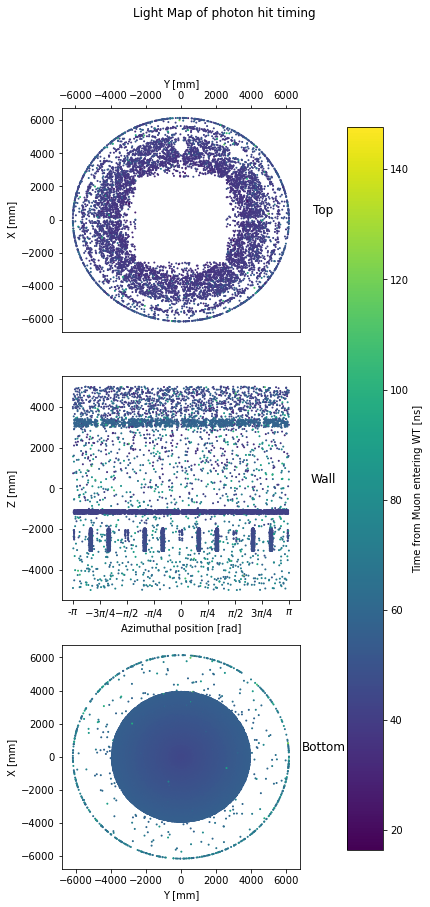

In [77]:
plotLightMapTime(top_hits, side_hits, bottom_hits, title="Light Map of photon hit timing", s=1)


## Looking at PMTs with Channel data

In [9]:
print(Data1.keys())

print(Data1['NumDetected'])
print(np.sum(Data1['NumDetected']))

dict_keys(['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 'PhotonWavelength', 'PhotonTime', 'DetectorHit'])
[174054]
174054


In [13]:
#for each photon hit, records which PMT is hit
ChannelIDs = Data1['ChannelIDs']
print(len(ChannelIDs))

#total number of channels hit for each muon (so max here is the total number of PMTs used)
NumHitChannels = Data1['NumHitChannels']
print(np.sum(Data1['NumHitChannels']))
# ChannelIDs

1
1


In [ ]:
PMTHit_pos = Data1['DetectorHit'].T
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(PMTHit_pos[0], PMTHit_pos[1], PMTHit_pos[2], 'blue')

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 20)

# 0, 90 - XZ plane; 90, 90 - top views

plt.show()

In [12]:
PhotonFlags_flip = GetPhotonFlags(Data1['Flags'])
HitTimes_detect = HitTimes[PhotonFlags_flip['SURFACE_DETECT']]

print(len(PMTHit_pos[0]), len(HitTimes), len(HitTimes_detect))


NameError: name 'HitTimes' is not defined

In [ ]:
#all photon wavelengths
# HitTimes = Data1['ChannelTimes'] 
HitTimes = Data1['PhotonTime'] 

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axs[0].hist(HitTimes, bins=200)
axs[0].set_xlabel("Time [ns]")
axs[0].set_ylabel("Number of photons")
axs[0].set_title("All Photons")

axs[1].hist(HitTimes_detect, bins=200)
axs[1].set_xlabel("Time [ns]")
axs[1].set_ylabel("Number of photons")
axs[1].set_title("Detected Photons")
plt.show() 

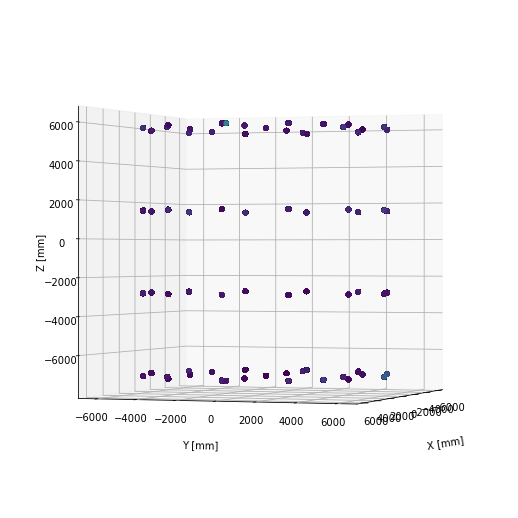